In [242]:
#imports
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim 
from torch.nn.functional import normalize

from typing import Callable, Tuple

import numpy as np

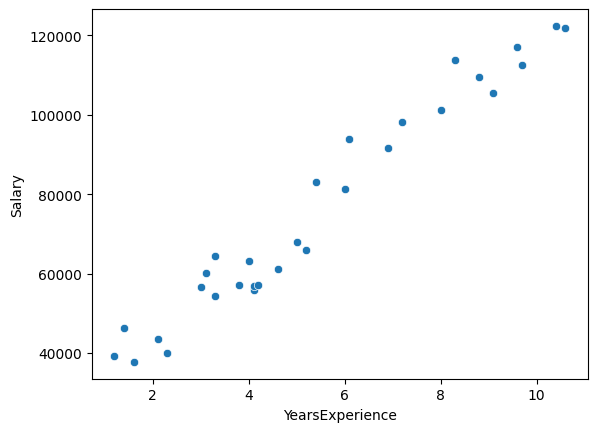

In [243]:
#load dataset
df = pd.read_csv("Salary_dataset.csv")
#print(df.head())

#explore/clean dataset
sns.scatterplot(data=df, x="YearsExperience", y="Salary") #, hue="Unnamed: 0")

#create test/training sets
y = df.pop("Salary").to_numpy(dtype="float32")
X = df.drop(['Unnamed: 0'], axis = 1).to_numpy(dtype="float32")

mean = y.mean()
std = y.std()


X,y = torch.tensor(X, dtype=torch.float32), normalize(torch.tensor(y, dtype=torch.float32).view(-1, 1), dim=0)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [244]:
# Use linear nn to predict the salery-experience relation
class Model(nn.Module):
    def __init__(self):
            super(Model, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(1, 5),    # First Linear layer: input size = 1, output size = 5
                nn.ReLU(),          # ReLU activation
                nn.Linear(5, 3),    # Second Linear layer: input size = 5, output size = 3
                nn.ReLU(),          # ReLU activation
                nn.Linear(3, 1)     # Third Linear layer: input size = 3, output size = 1
            )     
     

    def forward(self, x):
        return self.model(x)


In [245]:
def train(
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        criterion: Callable,
        trainloader: DataLoader,
        epochs: int,
        frequency: int = 100
):
    losses = list()
    for epoch in range(epochs):
        for x_torch, y_torch in trainloader:
            optimizer.zero_grad()

            # Step 1: Perform forward pass
            pred = model(x_torch)

            # Step 2: Calculate loss
            y_torch = y_torch.reshape(pred.shape)
            loss = criterion(y_torch, pred)

            # Step 3: Compute the partial derivatives of loss function
            loss.backward()
            
            # Step 4: Update the params
            optimizer.step()
            
        # analytics
        losses.append(loss.item())
            

        
        if epoch % frequency == 0:
            print(f'Epoch {epoch} Loss: {loss.item()}')
    return epochs, losses

In [246]:
LR = 0.01  # learning rate
EPOCHS = 1000

train_dataset = torch.utils.data.TensorDataset(
    X_train,
    y_train
)

model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = nn.MSELoss()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4)

epochs, losses = train(model, optimizer, criterion, trainloader, epochs=EPOCHS)

print(list(model.parameters()))


Epoch 0 Loss: 0.2602007985115051
Epoch 100 Loss: 0.000806197349447757
Epoch 200 Loss: 0.00014161255967337638
Epoch 300 Loss: 0.00011491893383208662
Epoch 400 Loss: 0.00011190049553988501
Epoch 500 Loss: 0.00011100588017143309
Epoch 600 Loss: 0.00011043345875805244
Epoch 700 Loss: 0.00010998454672517255
Epoch 800 Loss: 0.00010962395026581362
Epoch 900 Loss: 0.00010933695739367977
[Parameter containing:
tensor([[-0.9337],
        [ 0.1114],
        [ 0.6241],
        [-0.8332],
        [ 0.7918]], requires_grad=True), Parameter containing:
tensor([-0.8677, -0.4032, -0.0235, -0.1593,  0.3677], requires_grad=True), Parameter containing:
tensor([[ 0.3756,  0.3536, -0.0444, -0.3445, -0.1329],
        [ 0.2335, -0.3470, -0.3788,  0.2701,  0.0634],
        [-0.4374, -0.1035,  0.1966,  0.4252,  0.3804]], requires_grad=True), Parameter containing:
tensor([ 0.2821, -0.2876, -0.1429], requires_grad=True), Parameter containing:
tensor([[-0.0766,  0.1538,  0.0503]], requires_grad=True), Parameter co

<Axes: xlabel='None', ylabel='None'>

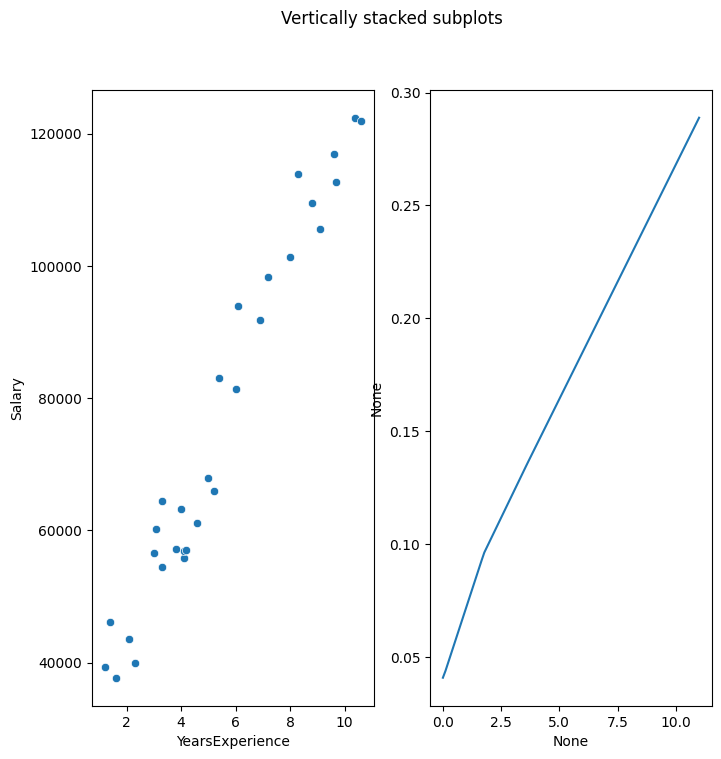

In [266]:
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)

df = pd.read_csv("Salary_dataset.csv")


X_space = torch.tensor(np.linspace(0,11,100), dtype=torch.float32).view(-1,1)
with torch.no_grad():
    y_res = model(X_space)


fig, axs = plt.subplots(1, 2,figsize=(8, 8))
fig.suptitle('Vertically stacked subplots')


sns.scatterplot(data=df, x="YearsExperience", y="Salary",ax=axs[0])
sns.lineplot(x=X_space.flatten(), y=y_res.flatten(),ax=axs[1])



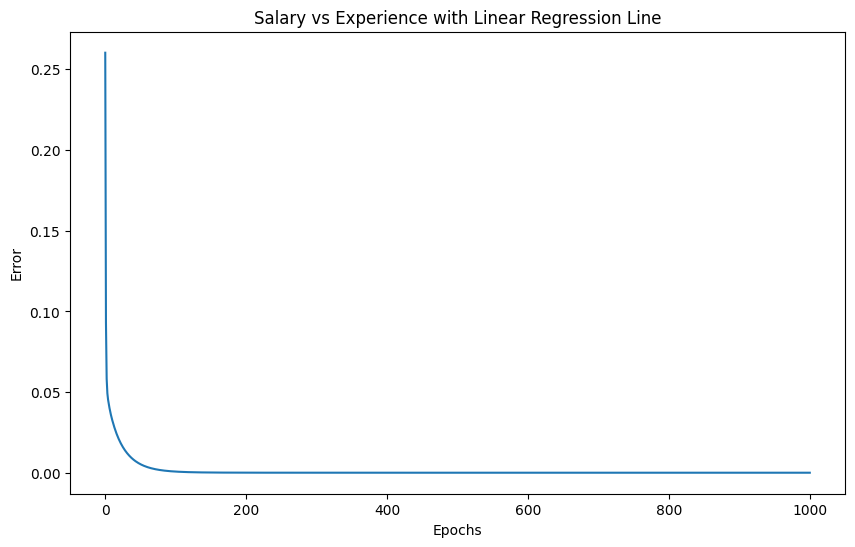

In [248]:
x_space = np.linspace(0,epochs,len(losses))
plt.figure(figsize=(10, 6))

sns.lineplot(x=x_space,y=losses)


plt.xlabel("Epochs")  # x-axis label
plt.ylabel("Error")  # y-axis label (customized)
# Plot title
plt.title("Salary vs Experience with Linear Regression Line")
plt.show()
